In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)


import torch
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("LIWC-22 Results - IMDB_Cleaned(in) - LIWC Analysis.csv")

In [3]:
df

,original_review,cleaned_review,sentiment,Analytic,Clout,Authentic,Tone
0,One of the other reviewers has mentioned that ...,reviewer mention watch oz episode hooked right...,positive,53.86,16.58,30.35,1.00
1,A wonderful little production. <br /><br />The...,wonderful little production film technique una...,positive,74.13,47.38,8.33,90.05
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive,58.60,18.97,64.98,98.65
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...,negative,76.00,73.29,34.62,30.05
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stun mr...,positive,92.19,74.34,46.20,79.49
...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,thought right good job creative original first...,positive,10.19,34.31,36.10,81.59
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogue bad act idiotic direct a...,negative,70.00,18.08,18.39,1.00
49997,I am a Catholic taught in parochial elementary...,catholic taught parochial elementary school nu...,negative,85.57,24.12,36.64,5.87
49998,I'm going to have to disagree with the previou...,go disagree previous comment side maltin secon...,negative,77.48,40.06,18.63,1.28


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   original_review  50000 non-null  object 
 1   cleaned_review   50000 non-null  object 
 2   sentiment        50000 non-null  object 
 3   Analytic         49998 non-null  float64
 4   Clout            49969 non-null  float64
 5   Authentic        49990 non-null  float64
 6   Tone             49918 non-null  float64
dtypes: float64(4), object(3)
memory usage: 2.7+ MB


In [5]:
import pandas as pd
import re

def clean_text_gentle(text):
    """
    Gentle preprocessing for SBERT - maintains sentence structure and readability
    while removing only the most problematic elements.
    """
    if pd.isna(text):
        return ""
    
    # Remove HTML tags (like <br />, <br/>, etc.)
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Replace multiple whitespace (including newlines, tabs) with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove excessive punctuation (3+ repeated punctuation marks)
    text = re.sub(r'[.]{3,}', '...', text)  # Keep ellipsis but normalize
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    
    # Clean up quotation marks (convert smart quotes to regular quotes)
    text = text.replace('"', '"').replace('"', '"')  # Left and right double quotes
    text = text.replace(''', "'").replace(''', "'")  # Left and right single quotes
    
    # Remove extra spaces around punctuation
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)
    text = re.sub(r'([,.!?;:])\s+', r'\1 ', text)
    
    # Clean up spacing around parentheses and quotes
    text = re.sub(r'\s+([)}\]])', r'\1', text)
    text = re.sub(r'([({[])\s+', r'\1', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply the function to create the new column
# Assuming your dataframe is called 'df'
df['cleaned_review_gentle'] = df['original_review'].apply(clean_text_gentle)

# Example usage and verification
print("Original text sample:")
print(df['original_review'].iloc[0][:200] + "...")
print("\nGently cleaned text sample:")
print(df['cleaned_review_gentle'].iloc[0][:200] + "...")
print("\nHeavily cleaned text sample (for comparison):")
print(df['cleaned_review'].iloc[0][:200] + "...")

# Check for any empty results after cleaning
empty_count = df['cleaned_review_gentle'].str.len().eq(0).sum()
print(f"\nNumber of empty results after gentle cleaning: {empty_count}")

# Display length comparison
print(f"\nAverage length comparison:")
print(f"Original: {df['original_review'].str.len().mean():.0f} characters")
print(f"Gentle cleaning: {df['cleaned_review_gentle'].str.len().mean():.0f} characters") 
print(f"Heavy cleaning: {df['cleaned_review'].str.len().mean():.0f} characters")

Original text sample:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

Gently cleaned text sample:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was i...

Heavily cleaned text sample (for comparison):
reviewer mention watch oz episode hooked right exactly happen first thing struck oz brutality unflinching scene violence set right word trust show faint hearted timid show pull punch regard drug sex v...

Number of empty results after gentle cleaning: 0

Average length comparison:
Original: 1309 characters
Gentle cleaning: 1286 characters
Heavy cleaning: 740 characters


In [6]:
df

,original_review,cleaned_review,sentiment,Analytic,Clout,Authentic,Tone,cleaned_review_gentle
0,One of the other reviewers has mentioned that ...,reviewer mention watch oz episode hooked right...,positive,53.86,16.58,30.35,1.00,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,wonderful little production film technique una...,positive,74.13,47.38,8.33,90.05,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive,58.60,18.97,64.98,98.65,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...,negative,76.00,73.29,34.62,30.05,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stun mr...,positive,92.19,74.34,46.20,79.49,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,thought right good job creative original first...,positive,10.19,34.31,36.10,81.59,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogue bad act idiotic direct a...,negative,70.00,18.08,18.39,1.00,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,catholic taught parochial elementary school nu...,negative,85.57,24.12,36.64,5.87,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,go disagree previous comment side maltin secon...,negative,77.48,40.06,18.63,1.28,I'm going to have to disagree with the previou...


In [7]:
print(df.isnull().sum())

original_review           0
cleaned_review            0
sentiment                 0
Analytic                  2
Clout                    31
Authentic                10
Tone                     82
cleaned_review_gentle     0
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   original_review        50000 non-null  object 
 1   cleaned_review         50000 non-null  object 
 2   sentiment              50000 non-null  object 
 3   Analytic               49998 non-null  float64
 4   Clout                  49969 non-null  float64
 5   Authentic              49990 non-null  float64
 6   Tone                   49918 non-null  float64
 7   cleaned_review_gentle  50000 non-null  object 
dtypes: float64(4), object(4)
memory usage: 3.1+ MB


EDA

In [9]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Dataset balance: 100.0%


Text(0, 0.5, '')

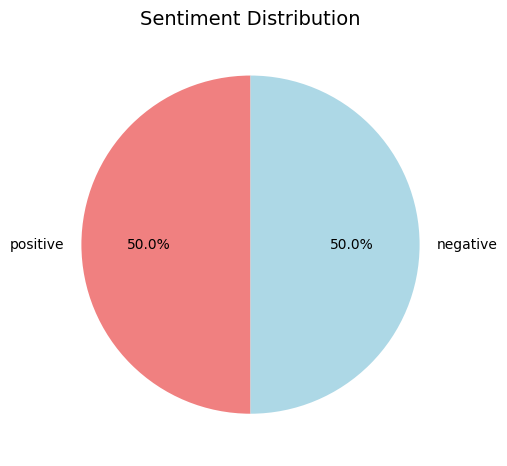

In [10]:
# Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_balance = sentiment_counts.min()/sentiment_counts.max()*100

print(f"\nSentiment Distribution:")
print(sentiment_counts)
print(f"Dataset balance: {sentiment_balance:.1f}%")
plt.figure(figsize=(12, 6))

# Pie chart
plt.subplot(1, 2, 1)
colors = ['lightcoral', 'lightblue']
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel('')



WORD FREQUENCY ANALYSIS
Most Common Words (Overall):
         Word  Frequency
0        make      46143
1        like      44310
2        well      32887
3        time      31561
4        good      29868
5   character      28361
6         bad      26747
7        even      25335
8       story      25276
9      really      23094
10       show      21924
11      scene      21450
12      great      20093
13       look      19951
14       much      19319
15        say      19288
16        end      18902
17        see      18595
18     people      18383
19       also      17977


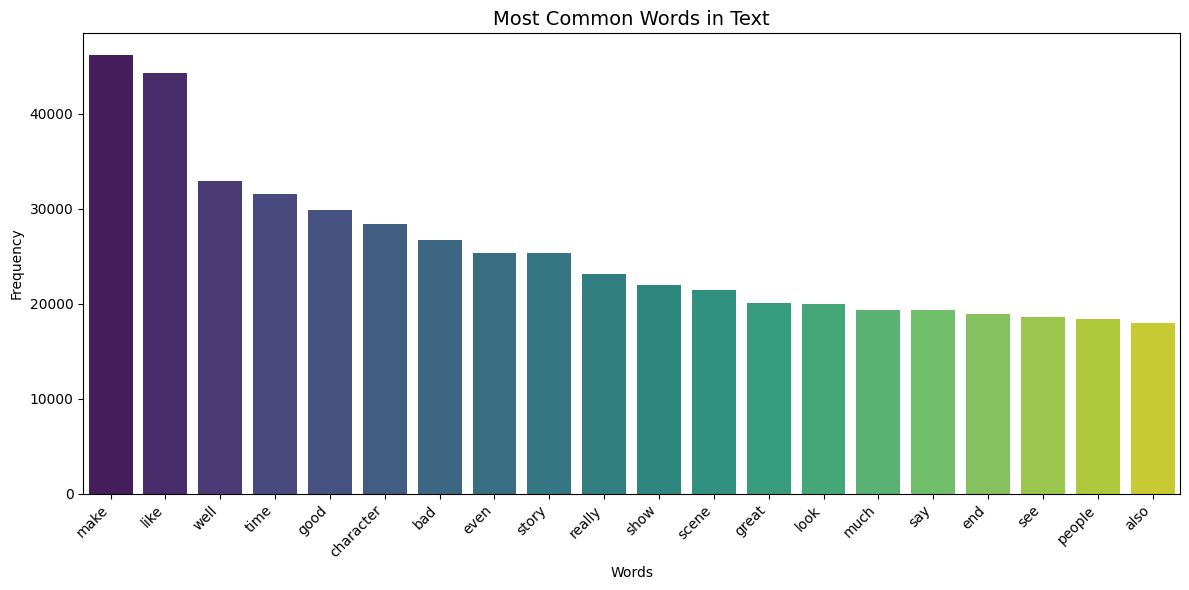

In [11]:
# Most Common Words Analysis
print("\n" + "="*50)
print("WORD FREQUENCY ANALYSIS")
print("="*50)

# Overall most common words
all_text = ' '.join(df['cleaned_review'].dropna())
all_words = all_text.split()
word_freq = Counter(all_words)
top_words_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

print("Most Common Words (Overall):")
print(top_words_df)

# Plot most common words
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='Word', y='Frequency', palette='viridis')
plt.title('Most Common Words in Text', fontsize=14)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Most common words by sentiment:

POSITIVE SENTIMENT - Top 15 words:
 1. make: 21144
 2. like: 20112
 3. well: 17536
 4. time: 16368
 5. good: 15094
 6. great: 14380
 7. story: 14185
 8. character: 14028
 9. show: 12187
10. love: 11888
11. also: 10793
12. really: 10739
13. scene: 10058
14. even: 9904
15. life: 9902

NEGATIVE SENTIMENT - Top 15 words:
 1. make: 24999
 2. like: 24198
 3. bad: 22093
 4. even: 15431
 5. well: 15351
 6. time: 15193
 7. good: 14774
 8. character: 14333
 9. really: 12355
10. look: 11777
11. scene: 11392
12. story: 11091
13. say: 10703
14. act: 10578
15. much: 10117


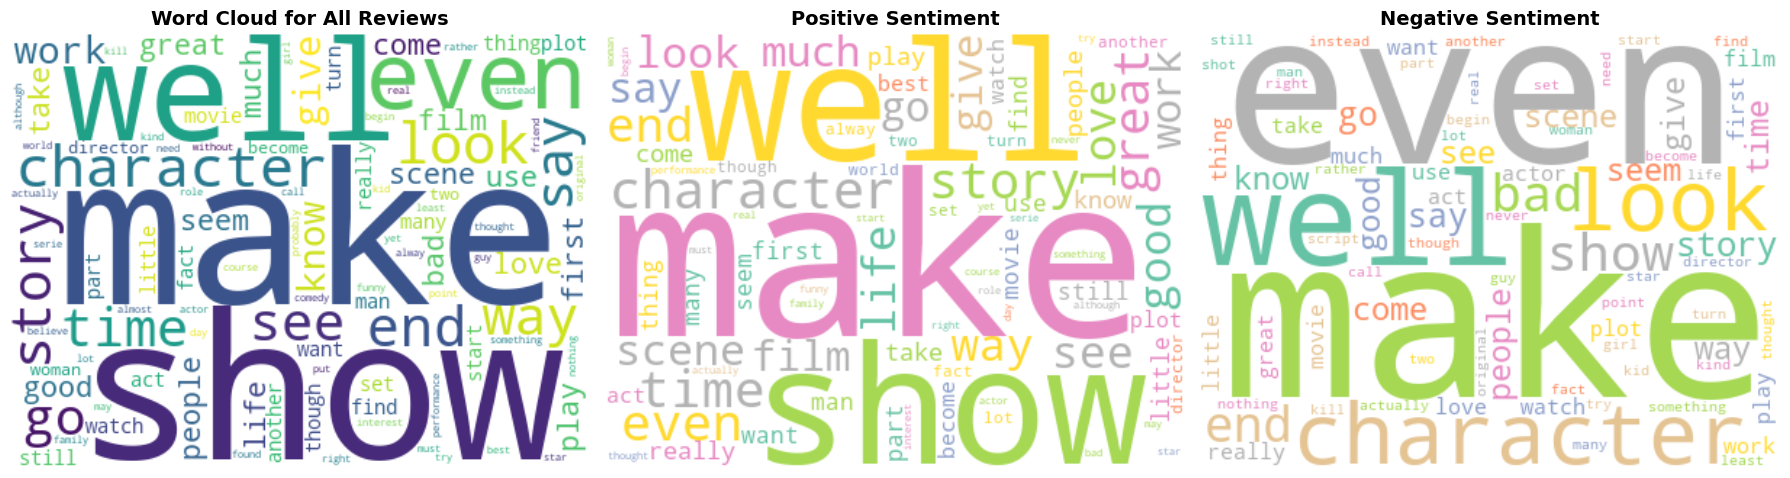

In [12]:
# Most common words by sentiment
print(f"\nMost common words by sentiment:")
for sentiment in df['sentiment'].unique():
    print(f"\n{sentiment.upper()} SENTIMENT - Top 15 words:")
    sentiment_text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_review'].dropna())
    sentiment_words = sentiment_text.split()
    sentiment_freq = Counter(sentiment_words)
    
    for i, (word, count) in enumerate(sentiment_freq.most_common(15), 1):
        print(f"{i:2d}. {word}: {count}")
        
# Word Clouds
plt.figure(figsize=(18, 6))

# Overall word cloud
plt.subplot(1, 3, 1)
all_text = ' '.join(df['cleaned_review'].dropna())
wordcloud_all = WordCloud(width=400, height=300, background_color='white',
                          max_words=100, colormap='viridis').generate(all_text)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews', fontsize=14, fontweight='bold')

# Word clouds by sentiment
sentiments = df['sentiment'].unique()
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(1, 3, i+1)
    sentiment_text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_review'].dropna())
    
    if len(sentiment_text.strip()) > 0:
        wordcloud = WordCloud(width=400, height=300, background_color='white',
                             max_words=80, colormap='Set2').generate(sentiment_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{sentiment.capitalize()} Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


LIWC PSYCHOLOGICAL SCORES ANALYSIS
LIWC Score Statistics:
        Analytic      Clout  Authentic       Tone
count  49998.000  49969.000  49990.000  49918.000
mean      59.498     39.754     33.429     42.340
std       24.146     24.726     24.645     32.485
min        1.000      1.000      1.000      1.000
25%       41.922     19.120     12.910     12.230
50%       62.595     37.310     28.110     36.580
75%       79.410     58.110     49.530     70.600
max       99.000     99.000     99.000     99.000

LIWC Score Correlations:
           Analytic  Clout  Authentic   Tone
Analytic      1.000  0.319     -0.260 -0.028
Clout         0.319  1.000     -0.509  0.033
Authentic    -0.260 -0.509      1.000 -0.013
Tone         -0.028  0.033     -0.013  1.000


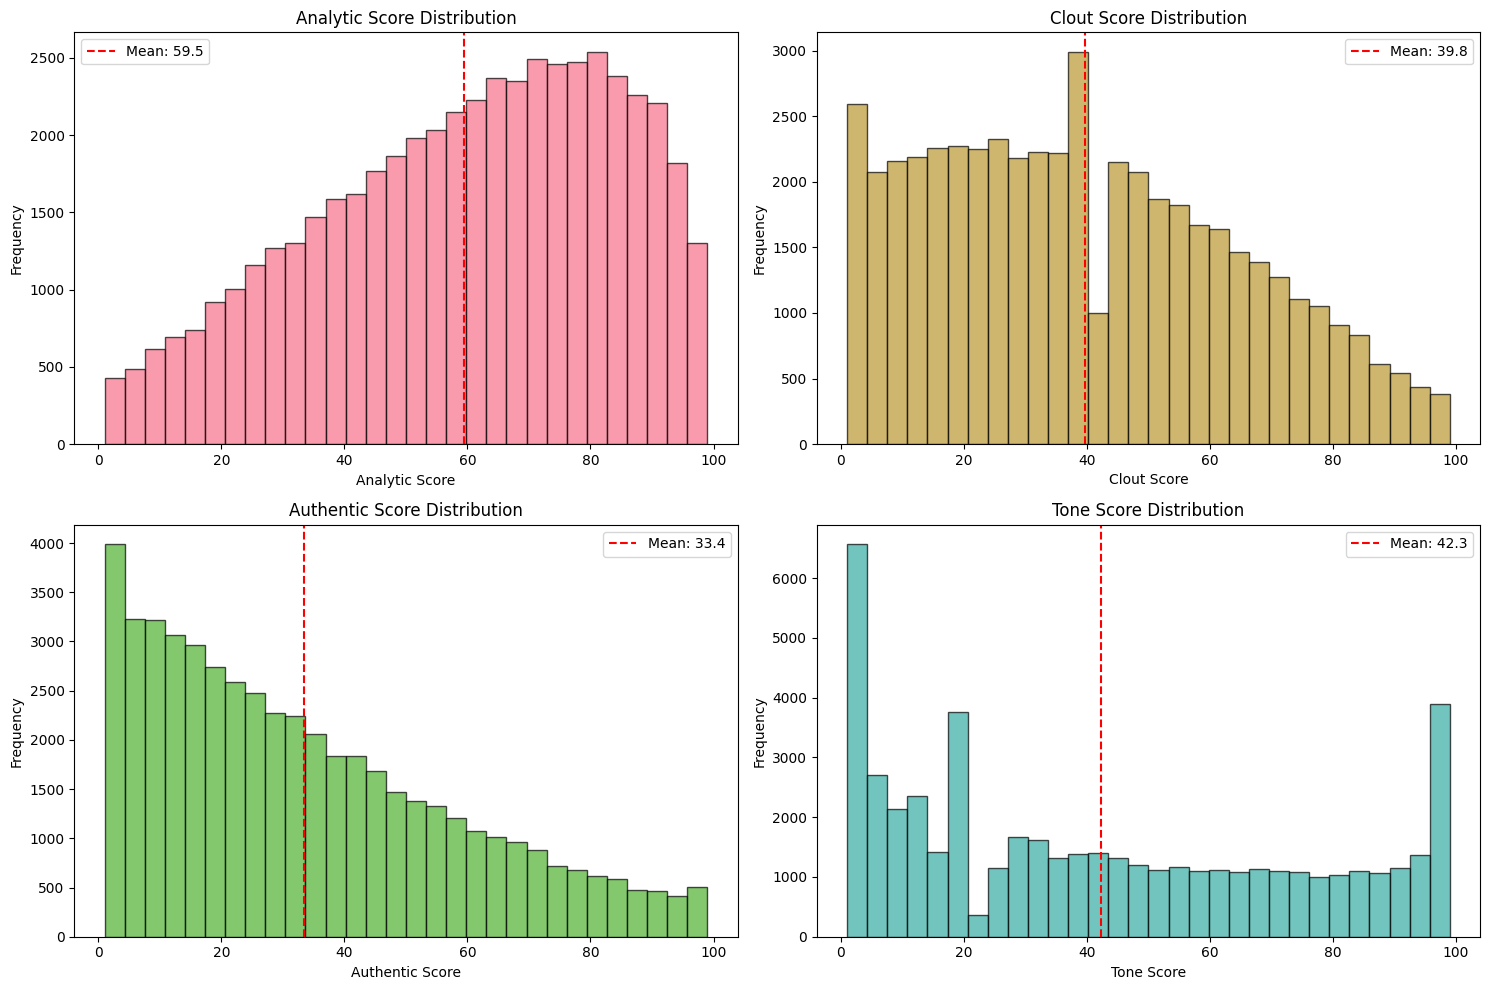

In [13]:
# LIWC Score Analysis
print("\n" + "="*50)
print("LIWC PSYCHOLOGICAL SCORES ANALYSIS")
print("="*50)

liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']

# LIWC statistics
liwc_stats = df[liwc_cols].describe()
print("LIWC Score Statistics:")
print(liwc_stats.round(3))

# LIWC correlations
print(f"\nLIWC Score Correlations:")
liwc_corr = df[liwc_cols].corr()
print(liwc_corr.round(3))

# %%
# LIWC Score Distributions
plt.figure(figsize=(15, 10))

for i, col in enumerate(liwc_cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col].dropna(), bins=30, alpha=0.7, color=f'C{i-1}', edgecolor='black')
    plt.title(f'{col} Score Distribution')
    plt.xlabel(f'{col} Score')
    plt.ylabel('Frequency')
    plt.axvline(df[col].mean(), color='red', linestyle='--', 
               label=f'Mean: {df[col].mean():.1f}')
    plt.legend()

plt.tight_layout()
plt.show()

Feature Engineering

TF-IDF Vectorization

In [14]:
print("Creating TF-IDF Features...")

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    min_df=3,        # Ignore terms that appear in fewer than 3 documents
    max_df=0.7,      # Ignore terms that appear in more than 70% of documents
    max_features=5000,  # Limit to top 5000 features
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform the cleaned text
tfidf_matrix = tfidf.fit_transform(df['cleaned_review'])
tfidf_feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_feature_names)}")
print(f"First 10 features: {tfidf_feature_names[:10]}")

# Convert to dense array for PCA (use sparse matrix for large datasets)
tfidf_dense = tfidf_matrix.toarray()

Creating TF-IDF Features...
TF-IDF matrix shape: (50000, 5000)
Number of features: 5000
First 10 features: ['aaron' 'abandon' 'abc' 'ability' 'able' 'absence' 'absent' 'absolute'
 'absolutely' 'absolutely love']


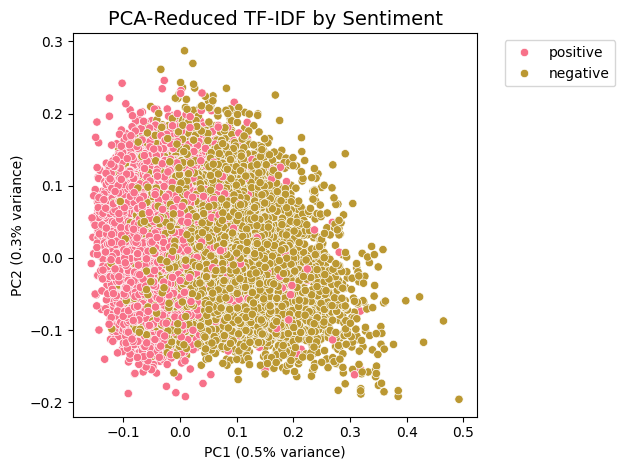

In [39]:
# Reduce matrix to 2D
pca_tfidf = PCA(n_components=2)
tfidf_pca_result = pca_tfidf.fit_transform(tfidf_dense)

# Attach reduced 2D back to original dataframe for future use
df[['tfidf_Dim1','tfidf_Dim2']] = tfidf_pca_result

# Plot with correct column name
sns.scatterplot(df, x='tfidf_Dim1', y='tfidf_Dim2', hue='sentiment')
plt.title('PCA-Reduced TF-IDF by Sentiment', fontsize=14)
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()

LIWC

In [16]:
print("\nPreparing LIWC Features...")

liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']

# Check missing values
print("Missing values in LIWC features:")
for col in liwc_cols:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing} ({(missing/len(df)*100):.1f}%)")


Preparing LIWC Features...
Missing values in LIWC features:
  Analytic: 2 (0.0%)
  Clout: 31 (0.1%)
  Authentic: 10 (0.0%)
  Tone: 82 (0.2%)


In [17]:
liwc_features = df[liwc_cols].copy()

# Tone missing = neutral (50)
liwc_features['Tone'] = liwc_features['Tone'].fillna(50) # Technical content lacks emotional tone

# Other features = median
liwc_features = liwc_features.fillna(liwc_features.median()) # Preserves natural data distribution for insufficient text content

LIWC PCA explained variance ratio: [0.43401372 0.25167294]
Total variance explained: 68.6%


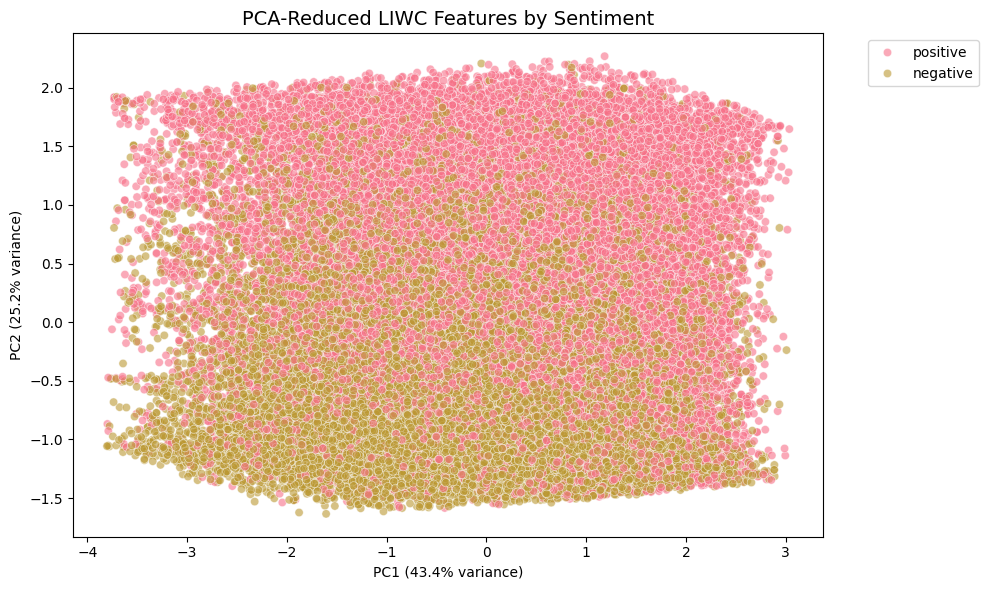

In [38]:
# Standardize LIWC features before PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
liwc_scaled = scaler.fit_transform(liwc_features)

# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca_liwc = PCA(n_components=2, random_state=42)
liwc_pca_result = pca_liwc.fit_transform(liwc_scaled)

# Add PCA results back to dataframe
df[['liwc_Dim1', 'liwc_Dim2']] = liwc_pca_result

print(f"LIWC PCA explained variance ratio: {pca_liwc.explained_variance_ratio_}")
print(f"Total variance explained: {pca_liwc.explained_variance_ratio_.sum():.1%}")

# Visualize PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='liwc_Dim1', y='liwc_Dim2', hue='sentiment', alpha=0.6)
plt.title('PCA-Reduced LIWC Features by Sentiment', fontsize=14)
plt.xlabel(f'PC1 ({pca_liwc.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_liwc.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

SBERT

In [19]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [20]:
#SBERT
print("Loading Sentence-BERT model...")

# Load pre-trained Sentence-BERT model
# 'all-MiniLM-L6-v2' is fast, lightweight, and high-quality
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Model loaded successfully!")
print(f"Model max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

# Prepare texts for SBERT
print("Preparing texts...")
texts_for_sbert = df['cleaned_review_gentle'].fillna('').tolist()
print(f"Total texts to process: {len(texts_for_sbert)}")

# Generate SBERT embeddings
print("Generating Sentence-BERT embeddings...")

sbert_embeddings = model.encode(
    texts_for_sbert,
    show_progress_bar=True,
    batch_size=64,  # Can handle larger batches than BERT
    convert_to_numpy=True,
    normalize_embeddings=False  # Set to True if you want L2 normalized embeddings
)

print(f"SBERT embeddings shape: {sbert_embeddings.shape}")
print(f"Embedding dimension: {sbert_embeddings.shape[1]}")
print("Embeddings generation completed!")


Loading Sentence-BERT model...
Model loaded successfully!
Model max sequence length: 256
Embedding dimension: 384
Preparing texts...
Total texts to process: 50000
Generating Sentence-BERT embeddings...


Batches: 100%|██████████| 782/782 [03:55<00:00,  3.32it/s]


SBERT embeddings shape: (50000, 384)
Embedding dimension: 384
Embeddings generation completed!


Applying PCA for visualization...
SBERT PCA explained variance ratio: [0.03573969 0.02860265]
Total variance explained: 6.4%


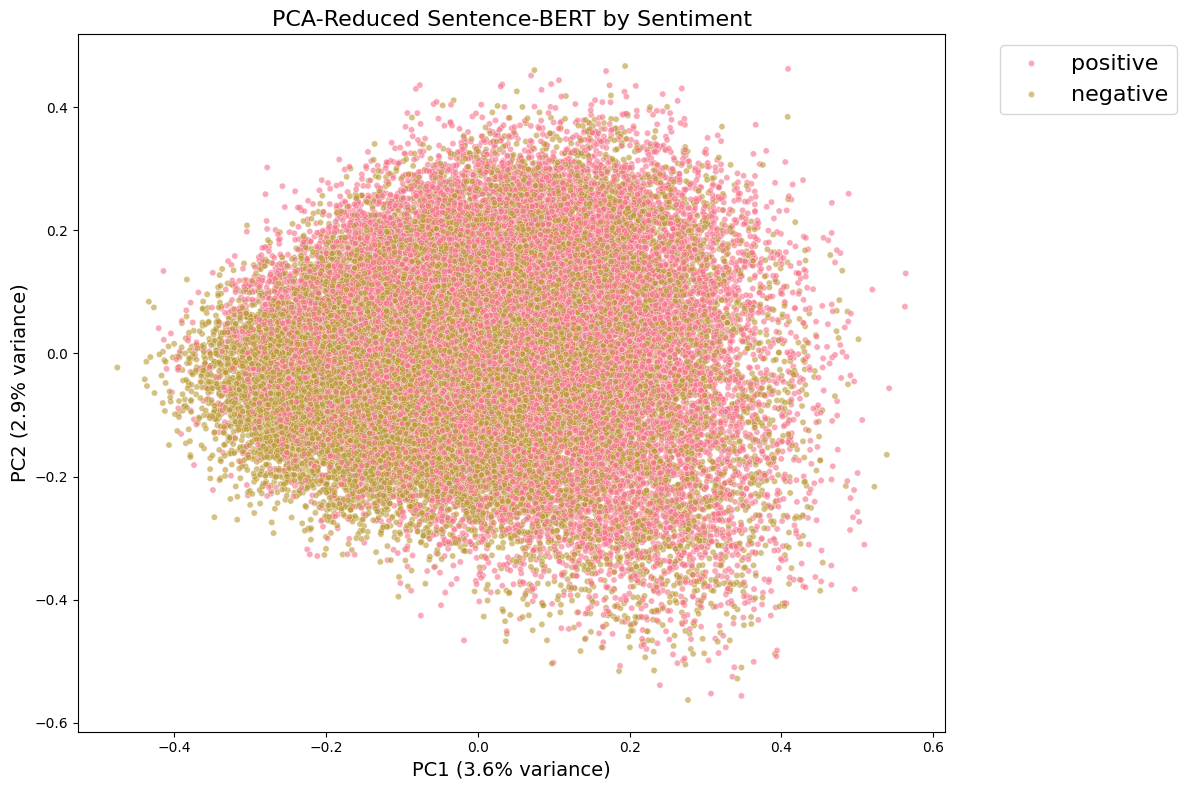

In [37]:
# Apply PCA for visualization
print("Applying PCA for visualization...")
pca_sbert = PCA(n_components=2, random_state=42)
sbert_pca_result = pca_sbert.fit_transform(sbert_embeddings)

# Add PCA results to dataframe
df[['sbert_Dim1', 'sbert_Dim2']] = sbert_pca_result

print(f"SBERT PCA explained variance ratio: {pca_sbert.explained_variance_ratio_}")
print(f"Total variance explained: {pca_sbert.explained_variance_ratio_.sum():.1%}")

# Visualization 1: All categories (will be crowded but shows full picture)
plt.figure(figsize=(12, 8))
sns.scatterplot(df, x='sbert_Dim1', y='sbert_Dim2', hue='sentiment', alpha=0.6, s=20)
plt.title('PCA-Reduced Sentence-BERT by Sentiment', fontsize=16)
plt.xlabel(f'PC1 ({pca_sbert.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
plt.ylabel(f'PC2 ({pca_sbert.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()

Model Fitting

In [28]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'LinearSVM': LinearSVC(random_state=42, max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=42),
    
    # Add Hard Vote as LinearSVM doesn't support predict_proba in Soft Vote
    'Hard Voting': VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('svm', LinearSVC(random_state=42, max_iter=2000)), 
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='hard'
    )
}

# Prepare target variable 
y = df['sentiment']  

print(f"Target variable shape: {y.shape}")
print(f"Number of classes: {y.nunique()}")
print(f"Class distribution:\n{y.value_counts()}")

Target variable shape: (50000,)
Number of classes: 2
Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [29]:
# TF-IDF Features 
X_tfidf = tfidf_dense  # Your TF-IDF matrix
print(f"TF-IDF features shape: {X_tfidf.shape}")

# LIWC Features (standardized)
liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']
X_liwc_raw = liwc_features  # Your processed LIWC features
scaler_liwc = StandardScaler()
X_liwc = scaler_liwc.fit_transform(X_liwc_raw)
print(f"LIWC features shape: {X_liwc.shape}")

# SBERT Features
X_sbert = sbert_embeddings  # Your SBERT embeddings
print(f"SBERT features shape: {X_sbert.shape}")

# Store all feature sets
feature_sets = {
    'TF-IDF': X_tfidf,
    'LIWC': X_liwc,
    'SBERT': X_sbert
}

TF-IDF features shape: (50000, 5000)
LIWC features shape: (50000, 4)
SBERT features shape: (50000, 384)



EVALUATING MODELS WITH TF-IDF FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.722
Precision: 0.723
Recall: 0.720
F1-score: 0.721
CV Score: 0.723 (+/- 0.009)

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      5000
    positive       0.72      0.72      0.72      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



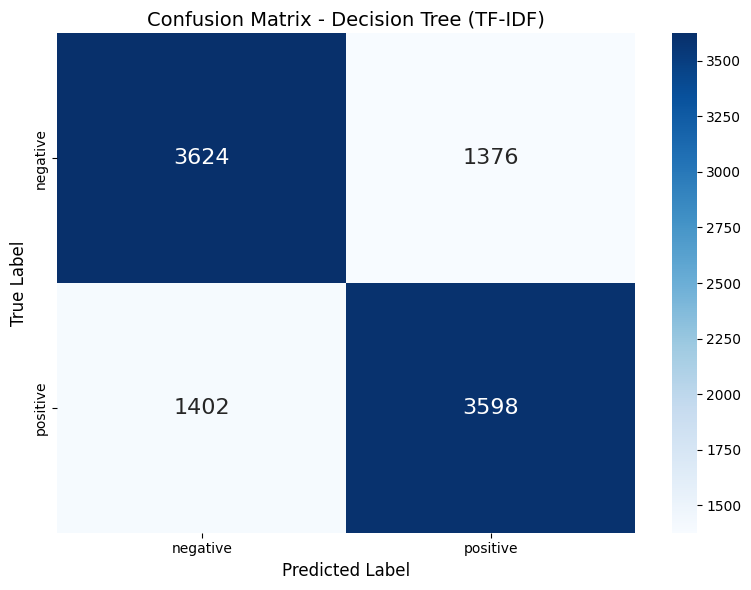


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.886
Precision: 0.876
Recall: 0.901
F1-score: 0.888
CV Score: 0.885 (+/- 0.004)

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



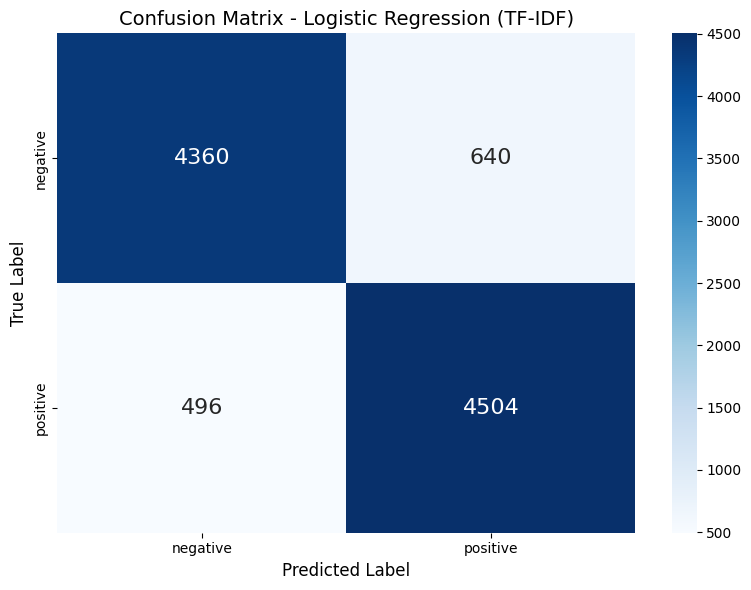


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.880
Precision: 0.871
Recall: 0.892
F1-score: 0.882
CV Score: 0.878 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5000
    positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



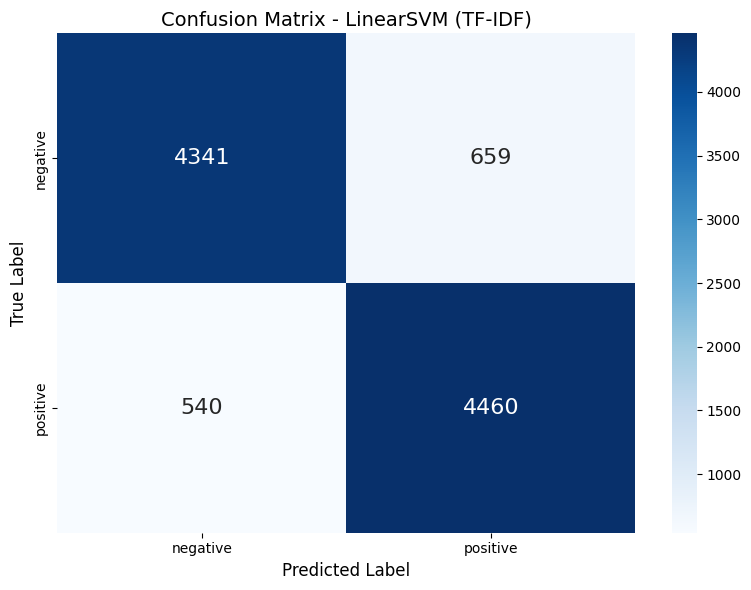


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.849
Precision: 0.857
Recall: 0.839
F1-score: 0.848
CV Score: 0.846 (+/- 0.006)

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      5000
    positive       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



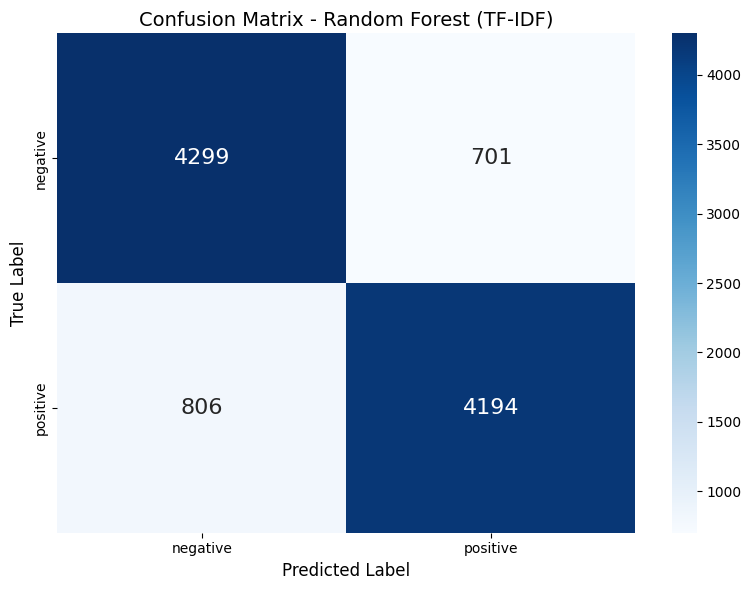


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.874
Precision: 0.898
Recall: 0.843
F1-score: 0.870
CV Score: 0.871 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.90      0.88      5000
    positive       0.90      0.84      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



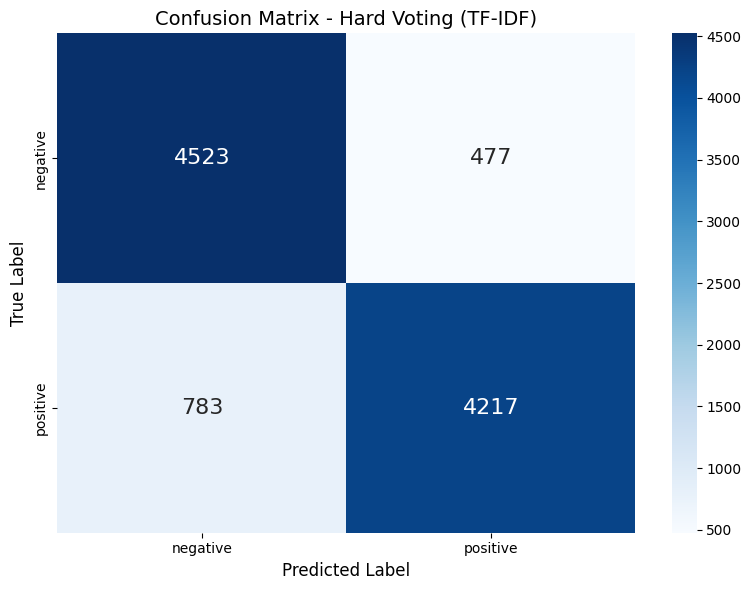

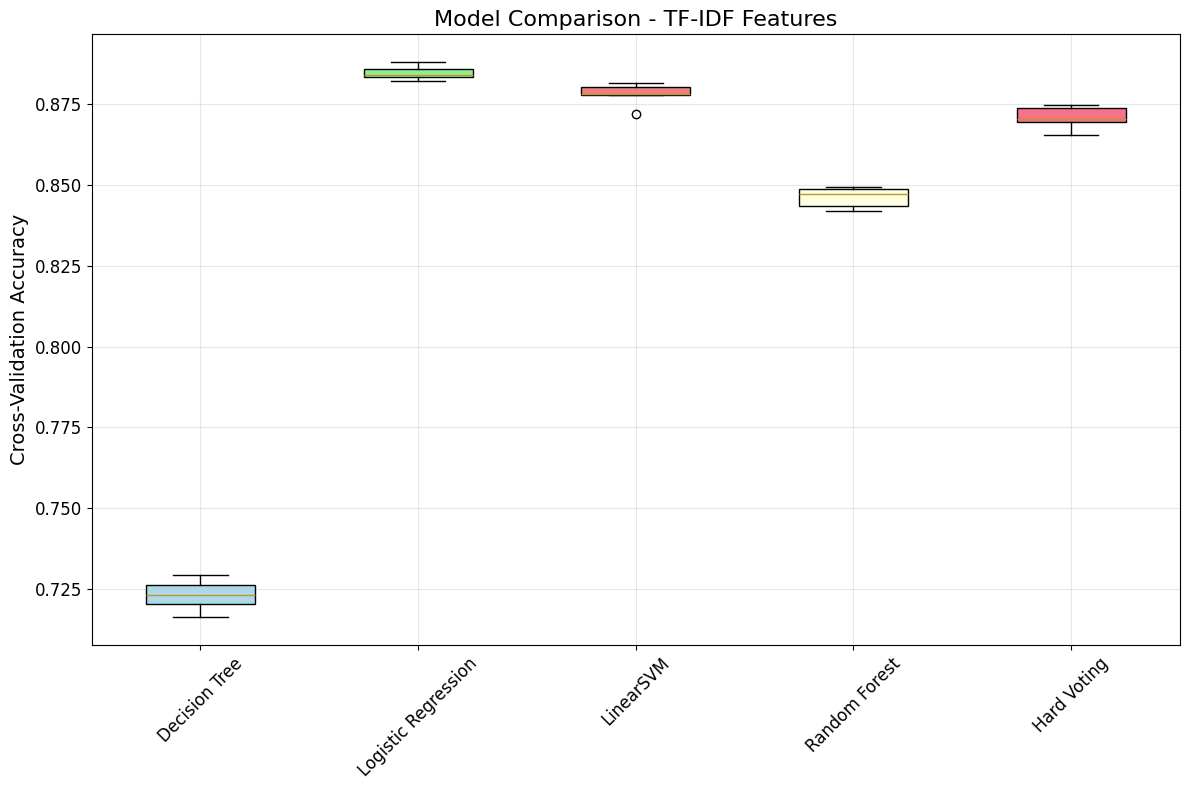


EVALUATING MODELS WITH LIWC FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.656
Precision: 0.657
Recall: 0.651
F1-score: 0.654
CV Score: 0.649 (+/- 0.011)

Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.66      0.66      5000
    positive       0.66      0.65      0.65      5000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



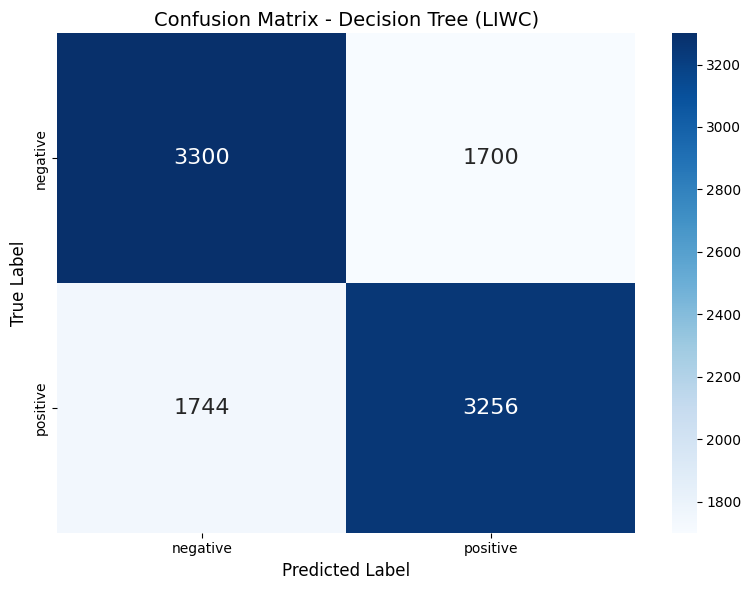


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.736
Precision: 0.745
Recall: 0.719
F1-score: 0.732
CV Score: 0.735 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.75      0.74      5000
    positive       0.74      0.72      0.73      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



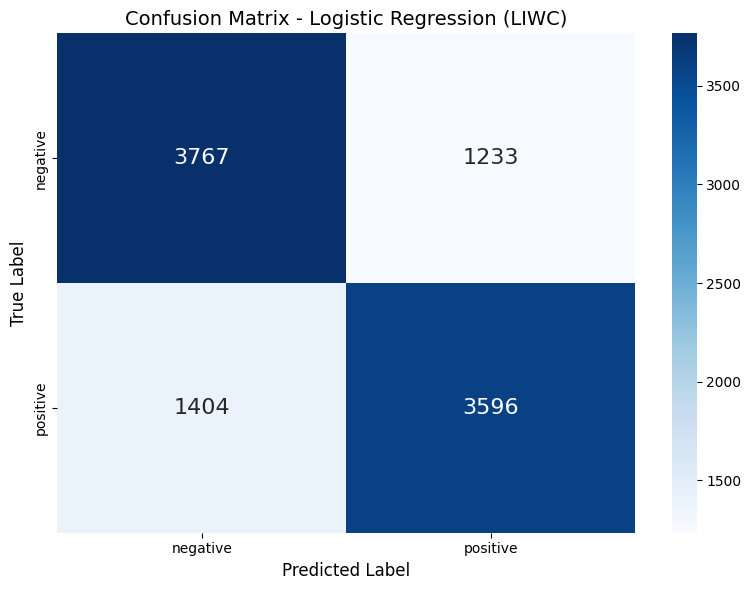


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.734
Precision: 0.747
Recall: 0.709
F1-score: 0.727
CV Score: 0.735 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74      5000
    positive       0.75      0.71      0.73      5000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



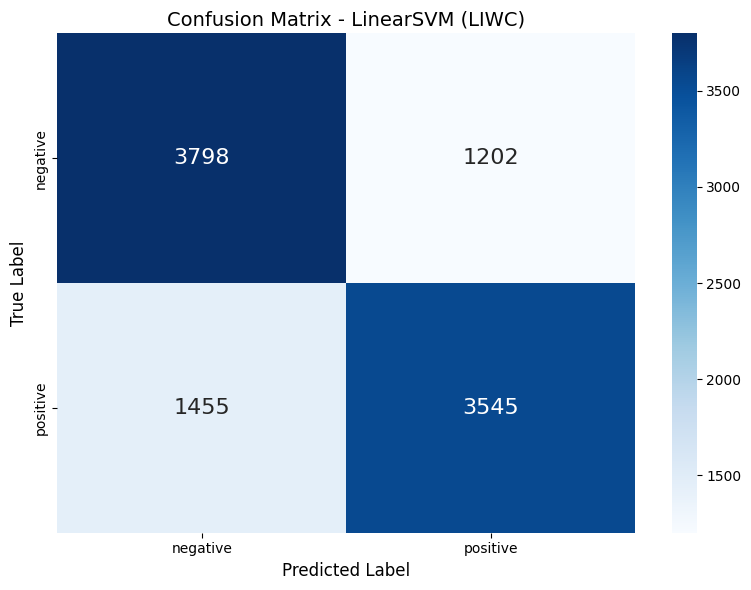


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.723
Precision: 0.725
Recall: 0.719
F1-score: 0.722
CV Score: 0.722 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.73      0.72      5000
    positive       0.72      0.72      0.72      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



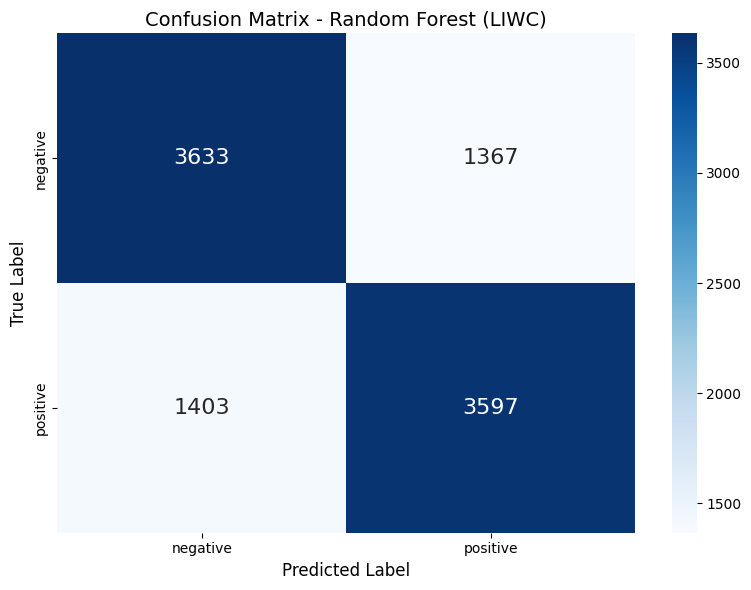


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.735
Precision: 0.764
Recall: 0.681
F1-score: 0.720
CV Score: 0.733 (+/- 0.006)

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.79      0.75      5000
    positive       0.76      0.68      0.72      5000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



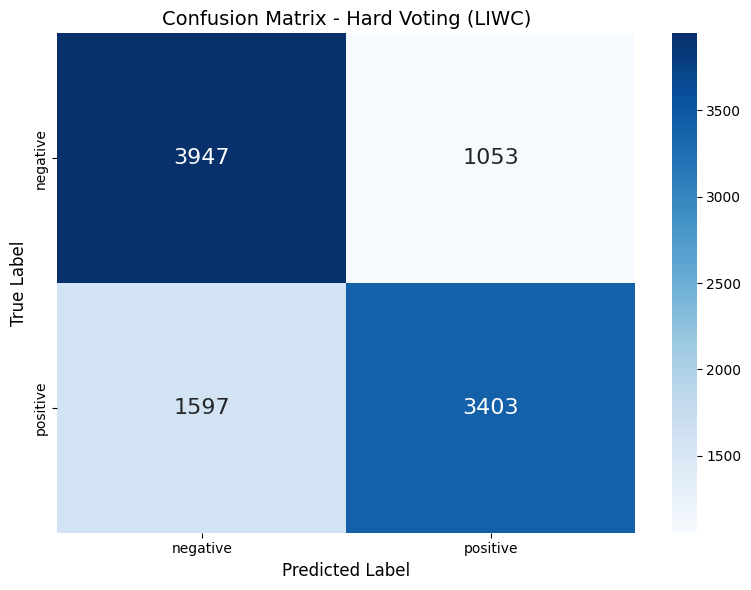

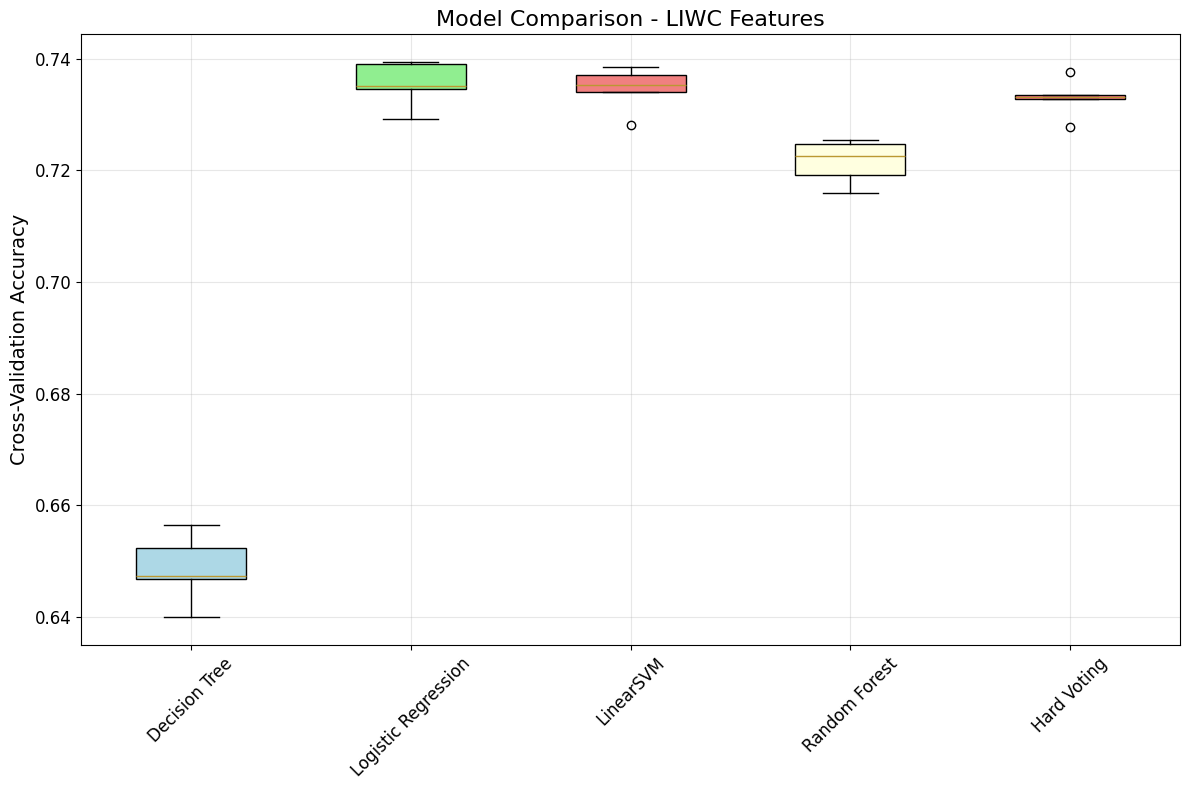


EVALUATING MODELS WITH SBERT FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.639
Precision: 0.640
Recall: 0.637
F1-score: 0.638
CV Score: 0.639 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.64      0.64      5000
    positive       0.64      0.64      0.64      5000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000



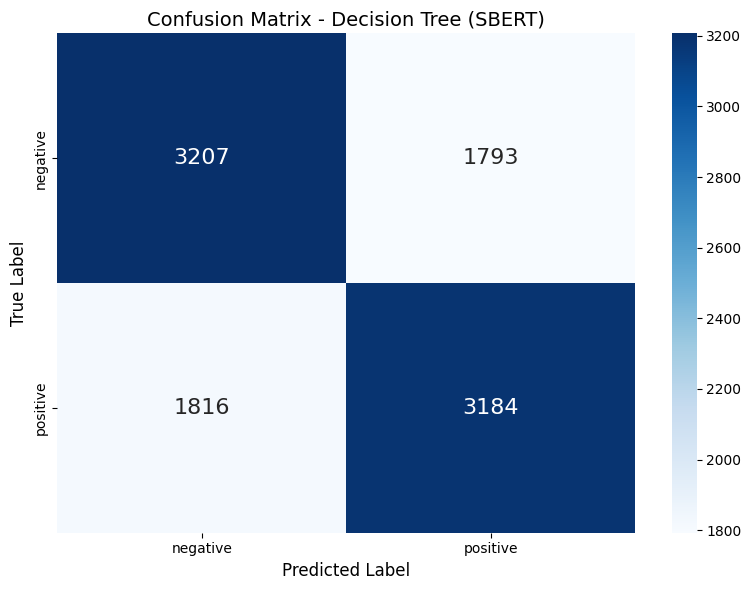


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.825
Precision: 0.826
Recall: 0.824
F1-score: 0.825
CV Score: 0.816 (+/- 0.005)

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.83      0.83      5000
    positive       0.83      0.82      0.82      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



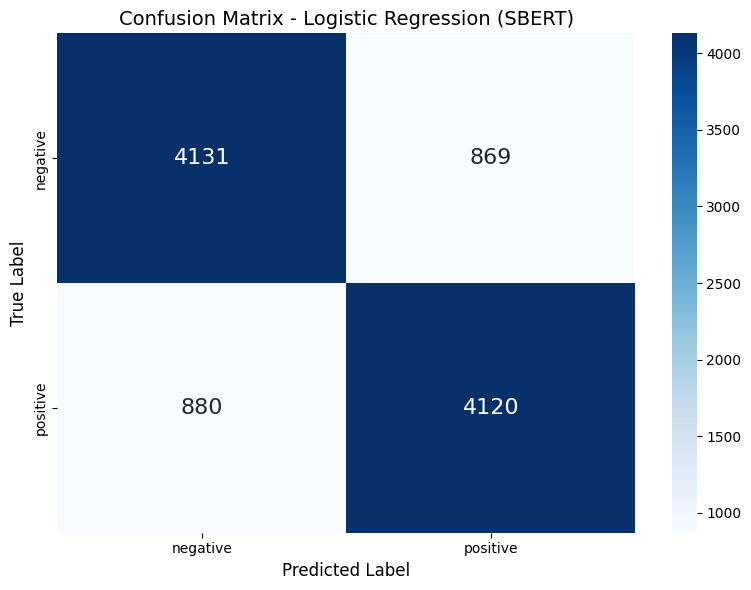


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.826
Precision: 0.825
Recall: 0.828
F1-score: 0.826
CV Score: 0.820 (+/- 0.004)

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.82      0.83      5000
    positive       0.82      0.83      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



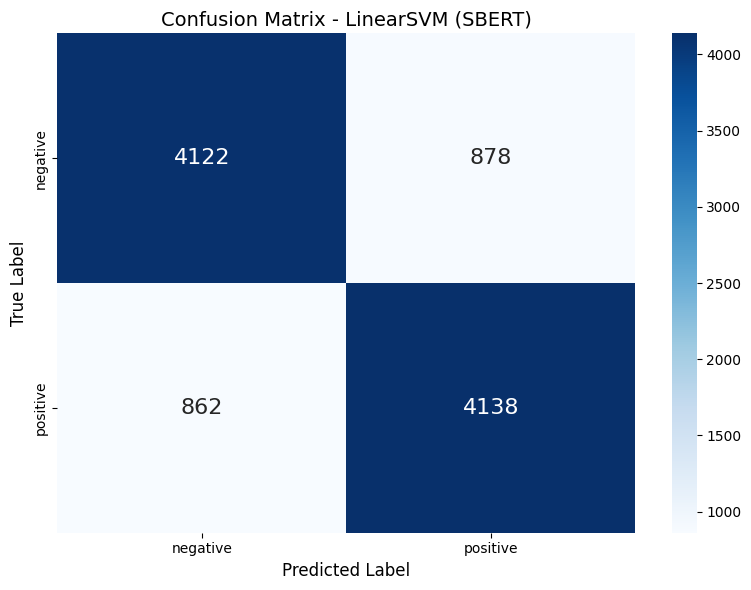


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.779
Precision: 0.772
Recall: 0.791
F1-score: 0.782
CV Score: 0.773 (+/- 0.004)

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78      5000
    positive       0.77      0.79      0.78      5000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



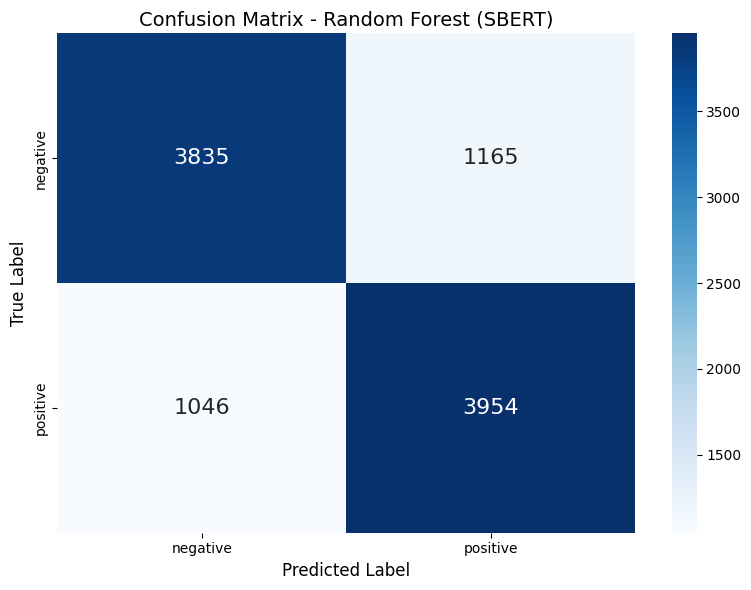


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.817
Precision: 0.847
Recall: 0.775
F1-score: 0.809
CV Score: 0.810 (+/- 0.005)

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.86      0.82      5000
    positive       0.85      0.77      0.81      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



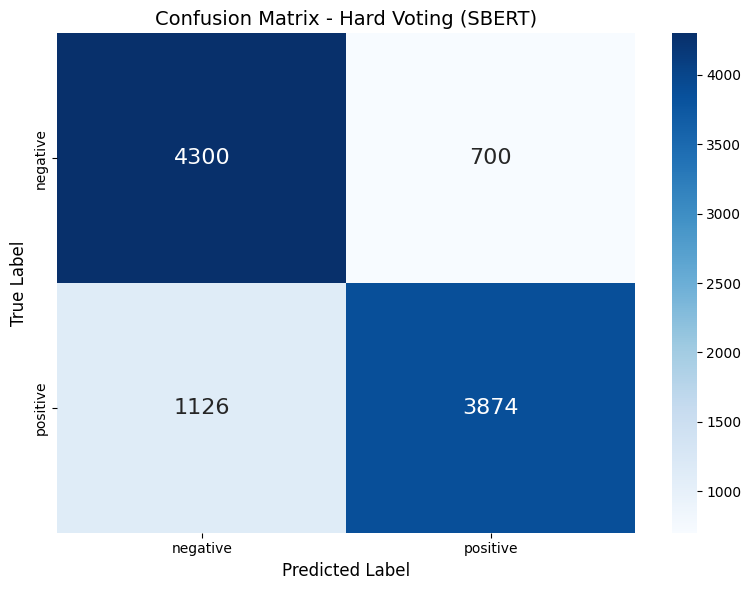

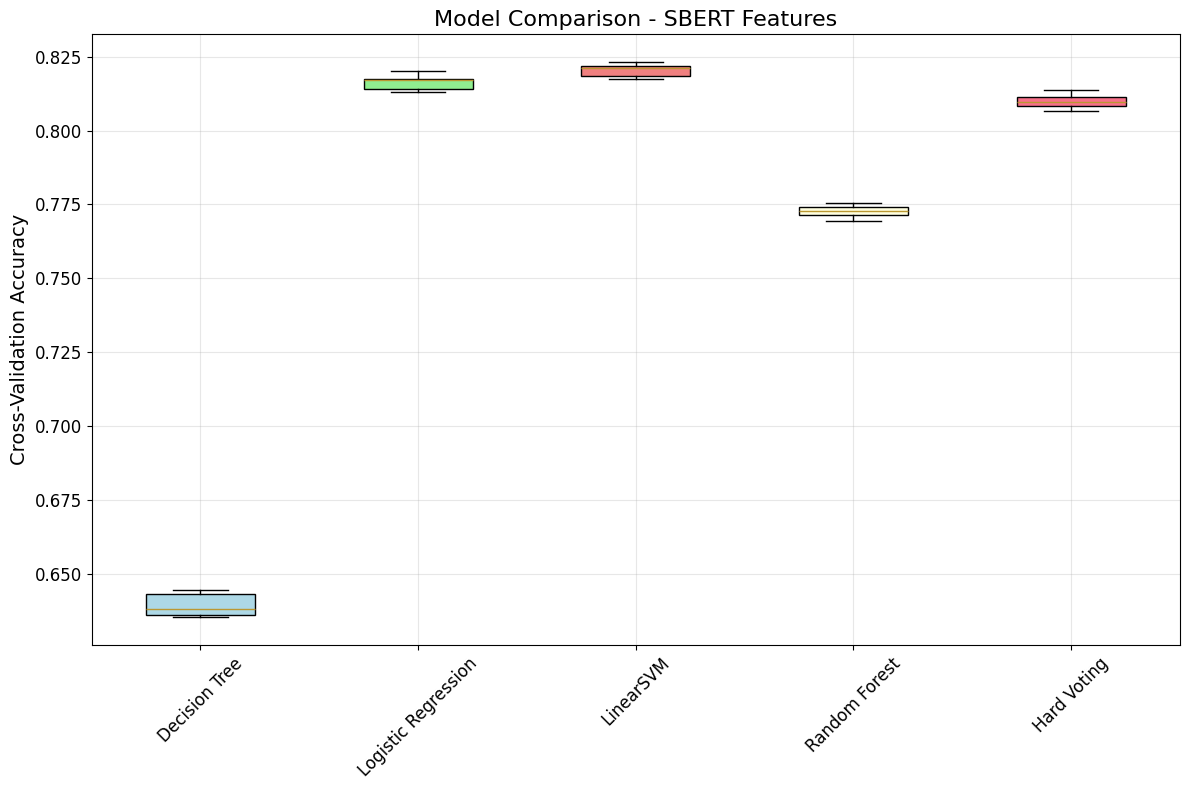

In [41]:
# Initialize dictionary to store all results
all_results = {}

# Iterate through each feature set
for feature_name, X in feature_sets.items():
    print(f"\n{'=' * 60}")
    print(f"EVALUATING MODELS WITH {feature_name.upper()} FEATURES")
    print(f"{'=' * 60}")
    
    # Split data with stratification for balanced classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Store results for this feature set
    feature_results = {}
    
    # Evaluate each model
    for model_name, model in models.items():
        print(f"\n{model_name} Evaluation:")
        print("-" * 40)
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate multiple metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary', pos_label='positive', zero_division=0)
        recall = recall_score(y_test, y_pred, average='binary', pos_label='positive', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='binary', pos_label='positive', zero_division=0)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        
        # Store all metrics
        feature_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std(),
            'CV_Scores': cv_scores
        }
        
        # Print results
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(y.unique()),
                    yticklabels=sorted(y.unique()),
                    annot_kws={'size': 16})
        plt.title(f'Confusion Matrix - {model_name} ({feature_name})', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Store results for this feature set
    all_results[feature_name] = feature_results
    
    # Model comparison box plot for this feature set
    plt.figure(figsize=(12, 8))
    cv_scores_list = [feature_results[name]['CV_Scores'] for name in models.keys()]
    bp = plt.boxplot(cv_scores_list, labels=models.keys(), patch_artist=True)
    plt.title(f'Model Comparison - {feature_name} Features', fontsize=16)
    plt.ylabel('Cross-Validation Accuracy', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.tight_layout()
    plt.show()

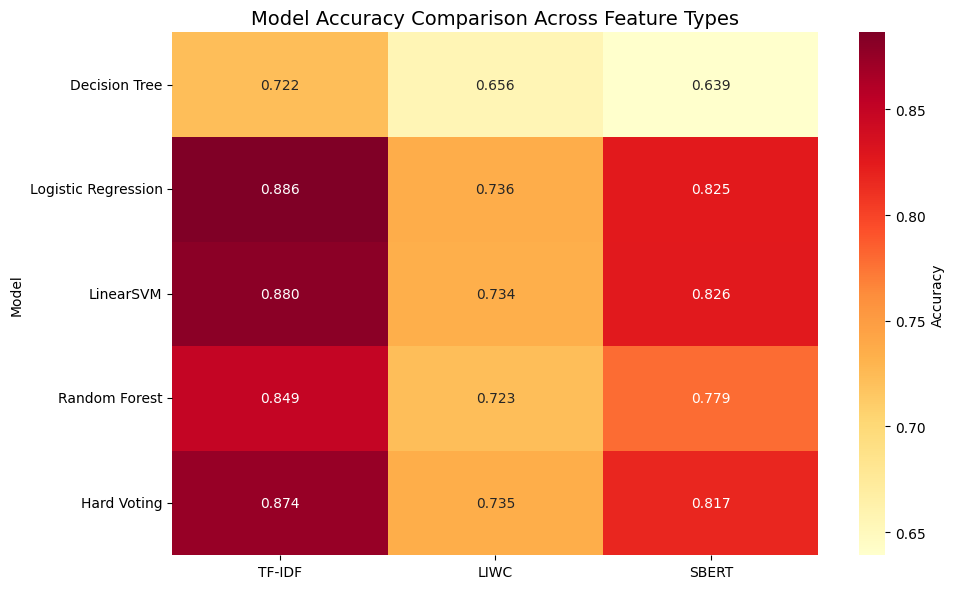

In [42]:
# Accuracy heatmap
accuracy_data = []
for model_name in models.keys():
    row = {'Model': model_name}
    for feature_name in feature_sets.keys():
        row[feature_name] = all_results[feature_name][model_name]['Accuracy']
    accuracy_data.append(row)

accuracy_df = pd.DataFrame(accuracy_data).set_index('Model')

plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Accuracy'})
plt.title('Model Accuracy Comparison Across Feature Types', fontsize=14)
plt.tight_layout()
plt.show()

In [43]:
# Print formatted table
print("="*70)
print("MODEL ACCURACY COMPARISON TABLE")
print("="*70)
print(accuracy_df.round(3))

# Print styled table with better formatting
print(f"\n{'='*80}")
print("DETAILED ACCURACY COMPARISON")
print(f"{'='*80}")

# Create a more detailed table with rankings
detailed_table = accuracy_df.round(3).copy()

# Add best model for each feature type (row-wise)
best_per_feature = detailed_table.idxmax(axis=0)
print(f"\nBest model per feature type:")
for feature, best_model in best_per_feature.items():
    best_score = detailed_table.loc[best_model, feature]
    print(f"  {feature:12s}: {best_model:18s} ({best_score:.3f})")

# Add best feature for each model (column-wise)
best_per_model = detailed_table.idxmax(axis=1)
print(f"\nBest feature type per model:")
for model, best_feature in best_per_model.items():
    best_score = detailed_table.loc[model, best_feature]
    print(f"  {model:18s}: {best_feature:12s} ({best_score:.3f})")

# Overall best combination
overall_best = detailed_table.max().max()
best_location = detailed_table.stack().idxmax()
print(f"\nOverall best performance:")
print(f"  {best_location[1]} + {best_location[0]}: {overall_best:.3f}")

# Create performance ranking table
print(f"\n{'='*60}")
print("PERFORMANCE RANKING (Highest to Lowest)")
print(f"{'='*60}")

ranking_data = []
for model in detailed_table.index:
    for feature in detailed_table.columns:
        ranking_data.append({
            'Rank': 0,  # Will be filled after sorting
            'Model': model,
            'Feature': feature,
            'Accuracy': detailed_table.loc[model, feature]
        })

ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
ranking_df['Rank'] = range(1, len(ranking_df) + 1)

print(ranking_df[['Rank', 'Model', 'Feature', 'Accuracy']].round(3))

MODEL ACCURACY COMPARISON TABLE
                     TF-IDF   LIWC  SBERT
Model                                    
Decision Tree         0.722  0.656  0.639
Logistic Regression   0.886  0.736  0.825
LinearSVM             0.880  0.734  0.826
Random Forest         0.849  0.723  0.779
Hard Voting           0.874  0.735  0.817

DETAILED ACCURACY COMPARISON

Best model per feature type:
  TF-IDF      : Logistic Regression (0.886)
  LIWC        : Logistic Regression (0.736)
  SBERT       : LinearSVM          (0.826)

Best feature type per model:
  Decision Tree     : TF-IDF       (0.722)
  Logistic Regression: TF-IDF       (0.886)
  LinearSVM         : TF-IDF       (0.880)
  Random Forest     : TF-IDF       (0.849)
  Hard Voting       : TF-IDF       (0.874)

Overall best performance:
  TF-IDF + Logistic Regression: 0.886

PERFORMANCE RANKING (Highest to Lowest)
    Rank                Model Feature  Accuracy
0      1  Logistic Regression  TF-IDF     0.886
1      2            LinearSVM  TF-I